In [1]:
%matplotlib inline
#import trtbrain
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import uproot

In [2]:
# %load lasso.py
import logging
import numpy as np
import uproot
import pandas as pd
import sklearn.utils as sku
from sklearn.model_selection import train_test_split
import collections

_logger = logging.getLogger(__name__)

def create_df(file_name, tree_name, branch_list, max_entries=-1, shuffle=False):

    tree   = uproot.open(file_name)[tree_name]
    nparrs = collections.OrderedDict()
    for bn in branch_list:
        nparrs[bn] = tree.array(bn)
        if bn == 'p':
            nparrs[bn] /= 1000.0
    df = pd.DataFrame.from_dict(nparrs)
    
    # TODO WARNING MC is weird, cut to a max pT of 200 GeV by hand!!!
    df = df[(df.pT <= 200000)]
    
    if shuffle:
        column_names = df.columns.values.tolist()
        shuffled = sku.shuffle(df.as_matrix())
        df = pd.DataFrame(shuffled,columns=column_names)
    if max_entries > 0:
        return df[:max_entries]
    return df

def create_df_tts_scale(sig_file_name, sig_tree_name, bkg_file_name, bkg_tree_name,
                        branch_list, sig_n=-1, bkg_n=-1, shuffle=False, test_size=0.4,
                        scale_style='default'):

    def make_sig_bkg(sig_file_name, sig_tree_name, bkg_file_name, bkg_tree_name,
                     branch_list, sig_n=-1, bkg_n=-1, shuffle=False):
        sig_df = create_df(sig_file_name,sig_tree_name,branch_list,max_entries=sig_n,shuffle=shuffle)
        bkg_df = create_df(bkg_file_name,bkg_tree_name,branch_list,max_entries=bkg_n,shuffle=shuffle)
        sig_mtx = sig_df.as_matrix()
        bkg_mtx = bkg_df.as_matrix()
        X = np.concatenate((sig_mtx,bkg_mtx))
        y = np.concatenate((np.ones(sig_mtx.shape[0]),
                            np.zeros(bkg_mtx.shape[0])))
        return (sig_df, bkg_df, X, y)

    df_sig, df_bkg, X, y = make_sig_bkg(sig_file_name,sig_tree_name,
                                        bkg_file_name,bkg_tree_name,
                                        branch_list,sig_n,bkg_n,shuffle)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)

    def scale_to_range(train,test,column,a=0,b=1):
        maximum = train[:,column].max()
        minimum = train[:,column].min()
        mmdiff = maximum - minimum
        train[:,column] = (b-a)*(train[:,column] - minimum)/(mmdiff) + a
        test[:,column]  = (b-a)*(test[:,column] - minimum)/(mmdiff) + a
        return dict(minimum=minimum,maximum=maximum,a=a,b=b)

    def standardization(train,test,column):
        mean, std = train[:,column].mean(), train[:,column].std()
        train[:,column] = (train[:,column] - mean)/std
        return dict(mean=mean,std=std)

    if isinstance(scale_style,str):
        for i in range(X_train.shape[1]):
            if scale_style == 'default':
                _ = scale_to_range(X_train,X_test,i)
            elif scale_style == 'symmetric':
                _ = scale_to_range(X_train,X_test,i,-1,1)
            elif scale_style == 'standardize':
                _ = standardization(X_train,X_test,i)
            elif scale_style == 'leave':
                continue

    if isinstance(scale_style,dict):
        for k, v in scale_style.items():
            if v == 'leave':
                continue
            elif v == 'default':
                _ = scale_to_range(X_train,X_test,k)
            elif v == 'symmetric':
                _ = scale_to_range(X_train,X_test,k,-1,1)
            elif v == 'standardize':
                _ = standardization(X_train,X_test,k)
            else:
                exit('bad scale style: '+v)

    return (df_sig, df_bkg, X_train, X_test, y_train, y_test)


In [3]:
# %load perf.py
import numpy as np
import scipy.interpolate as spi

class raw_roc(object):
    def __init__(self, sighist, bkghist, primary_axis='x',interpolate=False,
                 xbinrange=(1,1), ybinrange=(1,1), zbinrange=(1,1), npbinning=np.linspace(0.0,1.0,100)):

        sigPtConstruct = []
        bkgPtConstruct = []

        if isinstance(sighist,np.ndarray) and isinstance(bkghist,np.ndarray):
            binning = npbinning
            sigHist, sigEdges = np.histogram(sighist,bins=binning)
            bkgHist, bkgEdges = np.histogram(bkghist,bins=binning)
            self.sigInteg, self.bkgInteg = float(np.sum(sigHist)), float(np.sum(bkgHist))
            for i in range(len(sigHist)):
                x = float(np.sum(sigHist[i+1:]))/self.sigInteg
                y = float(np.sum(bkgHist[i+1:]))/self.bkgInteg
                sigPtConstruct.append(x)
                bkgPtConstruct.append(y)

        self.sigPoints = np.array(sigPtConstruct,copy=True,dtype='d')
        self.bkgPoints = np.array(bkgPtConstruct,copy=True,dtype='d')
        self.bmax, self.bmin = self.bkgPoints.max(), self.bkgPoints.min()
        self.smax, self.smin = self.sigPoints.max(), self.sigPoints.min()

        if interpolate:
            self.interpolation = spi.interp1d(self.sigPoints,self.bkgPoints,fill_value='extrapolate')

    def plot(self,on,*args,**kwargs):
        on.plot(self.sigPoints,self.bkgPoints,*args,**kwargs)


In [4]:
sig_file_name = 'all_el.root'
bkg_file_name = 'all_mu.root'
# data
# sig_tree  = 'electron_tags'
# bkg_tree  = 'muons'
# MC
sig_tree  = 'electron_mc'
bkg_tree  = 'muon_mc'

el_eprob = uproot.open(sig_file_name)[sig_tree].array('eProbHT')[:60000]
mu_eprob = uproot.open(bkg_file_name)[bkg_tree].array('eProbHT')[:60000]

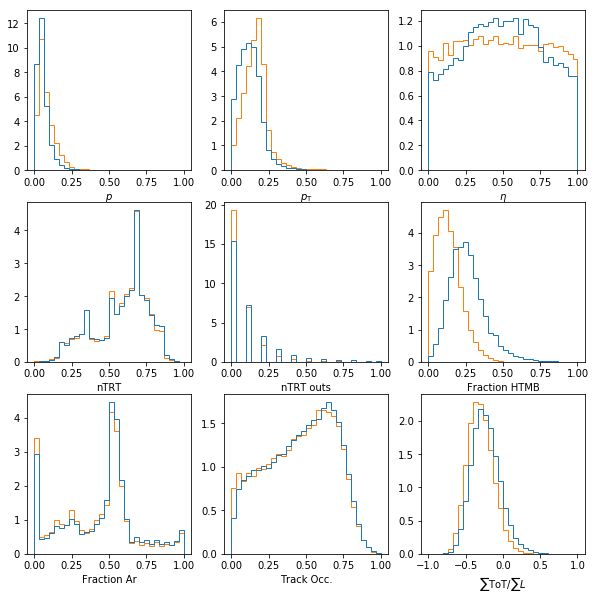

In [5]:
variables = OrderedDict(p='default',
                        pT='default',
                        eta='symmetric',
                        nTRThitsMan='default',
                        nTRTouts='default',
                        fHTMB='default',
                        fAr='default',
                        trkOcc='default',
                        sumToTsumL='default')

# TODO formerly just [k for k in variables], but was getting out of order for mepland in python2.7
hard_coded_order = ['p',
    'pT',
    'eta',
    'nTRThitsMan',
    'nTRTouts',
    'fHTMB',
    'fAr',
    'trkOcc',
    'sumToTsumL']

sig_df, bkg_df, X_train, X_test, y_train, y_test = create_df_tts_scale(
    sig_file_name,sig_tree,bkg_file_name,bkg_tree,
    hard_coded_order,test_size=0.333333,
    sig_n=40000,bkg_n=40000,shuffle=True,scale_style={i:v for i,(_,v) in enumerate(variables.items())}
)

fig, axarr = plt.subplots(3,3,figsize=(10,10))
fortitles = {0:['$p$',axarr[0,0]],
             1:['$p_\mathrm{T}$',axarr[0,1]],
             2:['$\eta$',axarr[0,2]],
             3:['nTRT',axarr[1,0]],
             4:['nTRT outs',axarr[1,1]],
             5:['Fraction HTMB',axarr[1,2]],
             6:['Fraction Ar',axarr[2,0]],
             7:['Track Occ.',axarr[2,1]],
             8:['$\sum\mathrm{ToT}/\sum L$',axarr[2,2]]}
for k,v in fortitles.items():
    v[1].hist([X_train[:,k][y_train>0.5],X_train[:,k][y_train<0.5]],label=['Sig','Bkg'],bins=30,histtype='step',normed=True)
    v[1].set_xlabel(v[0])
fig.savefig('allvars.pdf')

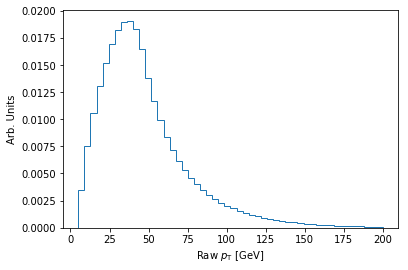

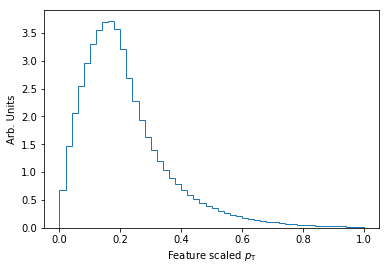

In [6]:
def scale_example(fname,tname,vname,a=0,b=1):
    arr = uproot.open(fname)[tname].array(vname,np.float32)# ,dtype=np.float32) # dtype= deprecated?
    if vname == 'p' or vname == 'pT':
        arr /= 1000.0
        
        # TODO WARNING MC is weird, cut to a max pT of 200 GeV by hand!!!
        selection_array = arr < 200
        arr = arr[selection_array]

    ma = arr.max()
    mi = arr.min()
    arr_scaled = (b-a)*(arr-mi)/(ma-mi)+a
    fig, ax = plt.subplots()
    ax.hist(arr,bins=50,histtype='step',normed=True)
    ax.set_ylabel('Arb. Units')
    ax.set_xlabel('Raw $p_\mathrm{T}$ [GeV]')
    fig.savefig('sce_nscaled.pdf')
    fig, ax = plt.subplots()
    ax.hist(arr_scaled,bins=50,histtype='step',normed=True)
    ax.set_ylabel('Arb. Units')
    ax.set_xlabel('Feature scaled $p_\mathrm{T}$')
    fig.savefig('sce_scaled.pdf')
scale_example(sig_file_name,sig_tree,'p')

In [7]:
class svm_tester(object):
    def __init__(self,X_train,y_train,X_test,y_test,C=1.0,kernel='rbf',tol=0.001,gamma='auto',probability=True):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.C = C
        self.kernel = kernel
        self.tol = tol
        self.gamma = gamma
        self.probability = probability
    def train(self):
        self.svm1 = svm.SVC(#C=self.C,
                            #kernel=self.kernel,
                            #tol=self.tol,
                            #gamma=self.gamma,
                            probability=self.probability).fit(self.X_train,self.y_train)
    def plot(self):
        self.elecs = self.svm1.decision_function(self.X_test[self.y_test>0.5])
        self.muons = self.svm1.decision_function(self.X_test[self.y_test<0.5])
        fig, ax = plt.subplots()
        ax.hist([self.elecs,self.muons],bins=50,histtype='step',normed=True,label=['Probe Electrons','Muons'])
        ax.set_xlabel('SVM output')
        ax.set_ylabel('Arb. Units')
        ax.legend()
        #ax.text('Default sklearn.svm.SVC settings')
        fig.savefig('histo.pdf')

        decs = self.svm1.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(y_test,decs)
        myroc = raw_roc(el_eprob,mu_eprob)
        fig, ax = plt.subplots()
        ax.plot(tpr,fpr,lw=2,label='SVM ROC, (Area: '+str(round(auc(tpr,fpr),2))+')')
        myroc.plot(on=ax,label='eProbabilityHT ROC, (Area: '+str(round(auc(myroc.sigPoints,myroc.bkgPoints),2))+')')
        ax.grid()
        ax.legend()
        ax.set_xlim([.4,1])
        ax.set_xlabel('True positive')
        ax.set_ylabel('False positive')
        fig.savefig('roc.pdf')

In [8]:
ttt = svm_tester(X_train,y_train,X_test,y_test)

In [9]:
ttt.train()

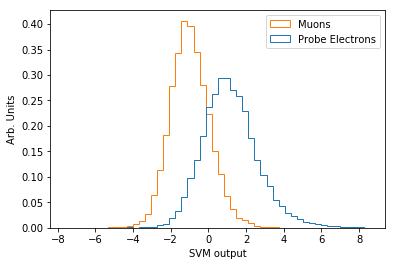

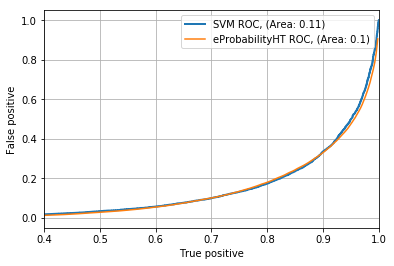

In [10]:
ttt.plot()